In [3]:
# Dependencias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Hiperparametros
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
IMAGE_SIZE = 224

Usando dispositivo: cpu


In [3]:
class UTKFaceDataset(Dataset):
    """
    Dataset customizado para UTKFace
    Estrutura do nome do arquivo: [idade]_[gênero]_[etnia]_[data].jpg
    Gênero: 0 = masculino, 1 = feminino
    """
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Extrair idade e gênero do nome do arquivo
        filename = os.path.basename(img_path)
        try:
            parts = filename.split('_')
            age = int(parts[0])
            gender = int(parts[1])
        except:
            # Se houver erro pula a imagem
            return None
        
        # Carregar imagem
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender

def load_data(data_dir):
    """
    Carrega os caminhos das imagens do dataset UTKFace
    """
    image_paths = []
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(data_dir, filename)
            try:
                parts = filename.split('_')
                age = int(parts[0])
                gender = int(parts[1])
                if 0 <= age <= 116 and gender in [0, 1]:
                    image_paths.append(img_path)
            except:
                continue
    
    print(f'Total de imagens encontradas: {len(image_paths)}')
    return image_paths

In [4]:
# Transformações de dados
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])


In [6]:
# Modelo Principal
class AgeGenderNet(nn.Module):
    """
    Arquitetura para predição de idade e gênero
    Usando ResNet18 como modelo base, com duas cabeças de saída
    """
    def __init__(self):
        super(AgeGenderNet, self).__init__()
        
        # ResNet18 pré-treinado como modelo base
        self.backbone = models.resnet18(pretrained=True)
        
        # Remover a última camada
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        # Cabeça para predição de idade (regressão)
        self.age_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        
        # Cabeça para predição de gênero (classificação binária)
        self.gender_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        # Extrair features principais com o modelo base
        features = self.backbone(x)
        
        # Predições de idade e gênero
        age = self.age_head(features)
        gender = self.gender_head(features)
        
        return age, gender

In [6]:
# Treinamento 
def train_epoch(model, dataloader, criterion_age, criterion_gender, optimizer, device, epoch, num_epochs):
    """
    Treina o modelo
    """
    model.train()
    running_loss = 0.0
    age_loss_total = 0.0
    gender_loss_total = 0.0
    correct_gender = 0
    total_samples = 0
    
    num_batches = len(dataloader)
    
    for batch_idx, (images, ages, genders) in enumerate(dataloader):
        images = images.to(device)
        ages = ages.float().unsqueeze(1).to(device)
        genders = genders.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        age_pred, gender_pred = model(images)
        
        # Calcular perdas
        loss_age = criterion_age(age_pred, ages)
        loss_gender = criterion_gender(gender_pred, genders)
        
        # Perda total (soma ponderada)
        loss = loss_age + loss_gender
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        age_loss_total += loss_age.item() * images.size(0)
        gender_loss_total += loss_gender.item() * images.size(0)
        
        # Acurácia de gênero
        _, predicted = torch.max(gender_pred.data, 1)
        correct_gender += (predicted == genders).sum().item()
        total_samples += images.size(0)
        
        # Exibir progresso em tempo real a cada 10 batches
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == num_batches:
            current_loss = running_loss / total_samples
            current_age_loss = age_loss_total / total_samples
            current_gender_loss = gender_loss_total / total_samples
            current_gender_acc = 100 * correct_gender / total_samples
            
            progress = (batch_idx + 1) / num_batches * 100
            print(f'\rÉpoca [{epoch+1}/{num_epochs}] | '
                  f'Batch [{batch_idx+1}/{num_batches}] ({progress:.1f}%) | '
                  f'Loss: {current_loss:.4f} | '
                  f'Age Los: {current_age_loss:.4f} | '
                  f'Gender Loss: {current_gender_loss:.4f} | '
                  f'Gender Acc: {current_gender_acc:.2f}%', end='')
    
    print()
    
    epoch_loss = running_loss / total_samples
    epoch_age_loss = age_loss_total / total_samples
    epoch_gender_loss = gender_loss_total / total_samples
    gender_accuracy = 100 * correct_gender / total_samples
    
    return epoch_loss, epoch_age_loss, epoch_gender_loss, gender_accuracy

def validate(model, dataloader, criterion_age, criterion_gender, device):
    """
    Valida o modelo
    """
    model.eval()
    running_loss = 0.0
    age_loss_total = 0.0
    gender_loss_total = 0.0
    correct_gender = 0
    total_samples = 0
    age_mae = 0.0
    
    with torch.no_grad():
        for images, ages, genders in dataloader:
            images = images.to(device)
            ages = ages.float().unsqueeze(1).to(device)
            genders = genders.to(device)
            
            # Forward pass
            age_pred, gender_pred = model(images)
            
            # Calcular perdas
            loss_age = criterion_age(age_pred, ages)
            loss_gender = criterion_gender(gender_pred, genders)
            loss = loss_age + loss_gender
            
            running_loss += loss.item() * images.size(0)
            age_loss_total += loss_age.item() * images.size(0)
            gender_loss_total += loss_gender.item() * images.size(0)
            
            # Métricas
            _, predicted = torch.max(gender_pred.data, 1)
            correct_gender += (predicted == genders).sum().item()
            total_samples += images.size(0)
            
            # MAE (Mean Absolute Error) para idade
            age_mae += torch.abs(age_pred - ages).sum().item()
    
    epoch_loss = running_loss / total_samples
    epoch_age_loss = age_loss_total / total_samples
    epoch_gender_loss = gender_loss_total / total_samples
    gender_accuracy = 100 * correct_gender / total_samples
    age_mae = age_mae / total_samples
    
    return epoch_loss, epoch_age_loss, epoch_gender_loss, gender_accuracy, age_mae

In [7]:
# Validação
def visualize_predictions(model, dataloader, device, num_images=8):
    """
    Visualiza algumas predições do modelo
    """
    model.eval()
    images_list = []
    ages_true = []
    ages_pred = []
    genders_true = []
    genders_pred = []
    
    with torch.no_grad():
        for images, ages, genders in dataloader:
            images = images.to(device)
            age_p, gender_p = model(images)
            
            for i in range(min(num_images, images.size(0))):
                img = images[i].cpu()
                images_list.append(img)
                ages_true.append(ages[i].item())
                ages_pred.append(age_p[i].item())
                genders_true.append(genders[i].item())
                _, pred_g = torch.max(gender_p[i], 0)
                genders_pred.append(pred_g.item())
                
                if len(images_list) >= num_images:
                    break
            
            if len(images_list) >= num_images:
                break
    
    # Plotar
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx in range(num_images):
        img = images_list[idx]
        # Desnormalizar imagem
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        gender_true_str = 'F' if genders_true[idx] == 1 else 'M'
        gender_pred_str = 'F' if genders_pred[idx] == 1 else 'M'
        
        title = f'Real: {ages_true[idx]:.0f}a, {gender_true_str}\n'
        title += f'Pred: {ages_pred[idx]:.0f}a, {gender_pred_str}'
        axes[idx].set_title(title)
    
    plt.tight_layout()
    plt.show()


1. Carregando dados
Total de imagens encontradas: 23708
Imagens de treino: 18966
Imagens de validação: 4742

2. Criando modelo


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Total de parâmetros: 11505347

3. Treinamento

ÉPOCA 1/30
Época [1/30] | Batch [593/593] (100.0%) | Loss: 198.5250 | Age Los: 197.8466 | Gender Loss: 0.6784 | Gender Acc: 58.03%

Validando...        
                                RESUMO DA ÉPOCA                                 
--------------------------------------------------------------------------------
TREINO                                   | VALIDAÇÃO                              
--------------------------------------------------------------------------------
Loss Total: 198.5250                    | Loss Total: 103.6736                   
Loss Idade: 197.8466                    | Loss Idade: 103.0001                   
Loss Gênero: 0.6784                     | Loss Gênero: 0.6735                    
Acurácia Gênero: 58.03                % | Acurácia Gênero: 58.48                %
                                         | MAE Idade: 7.10                        anos
-----------------------------------------------------------

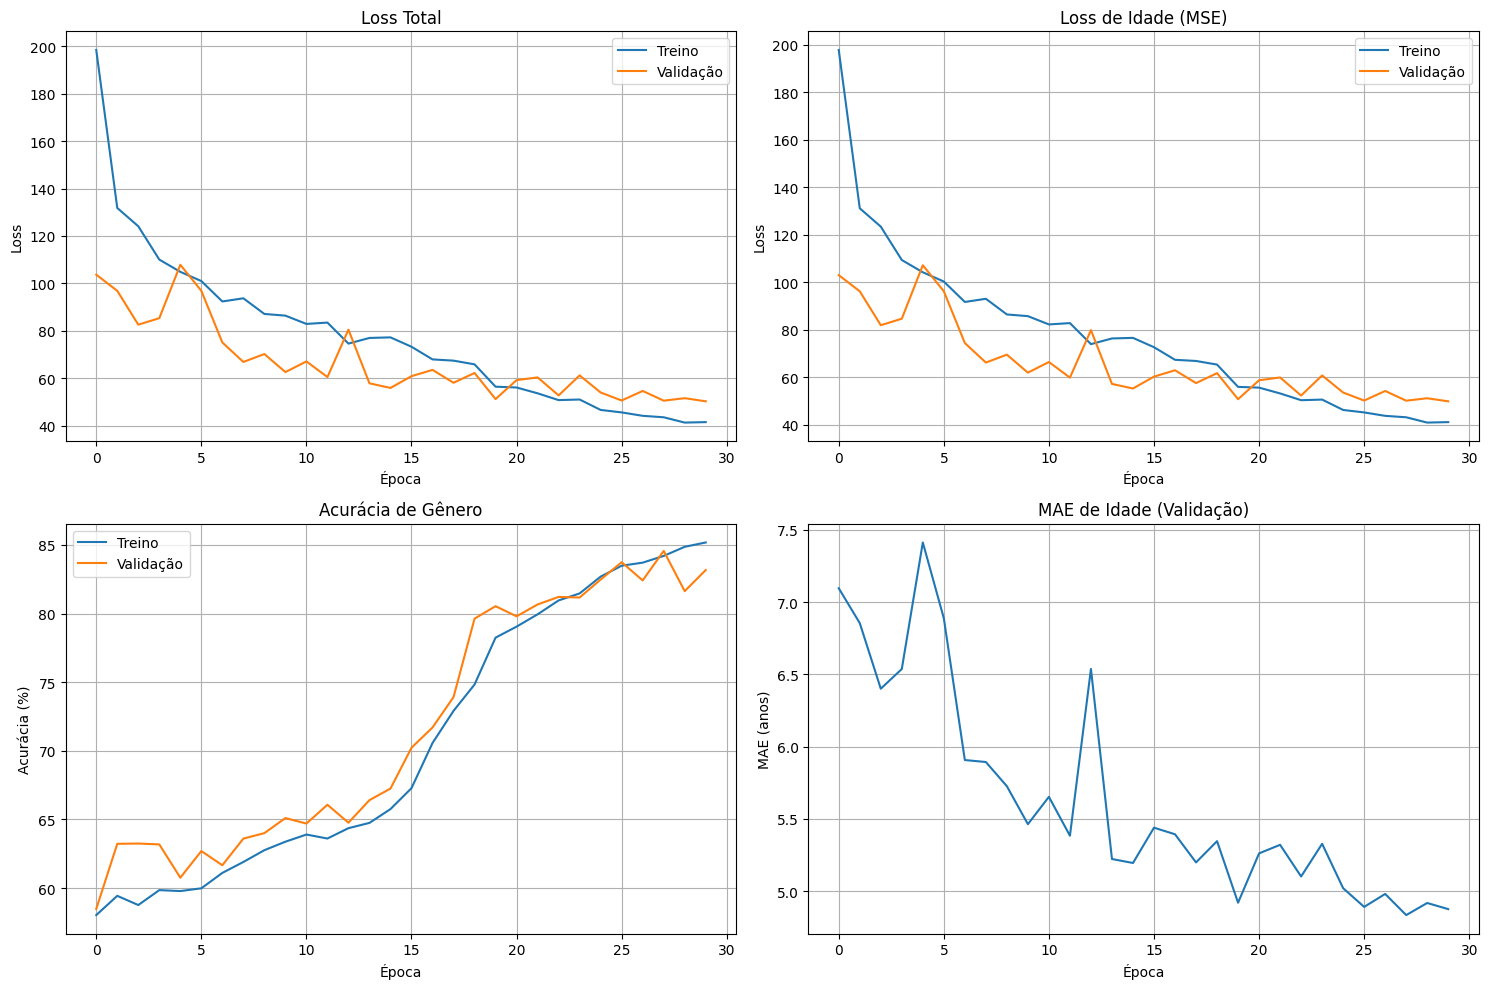


5. Visualizando predições


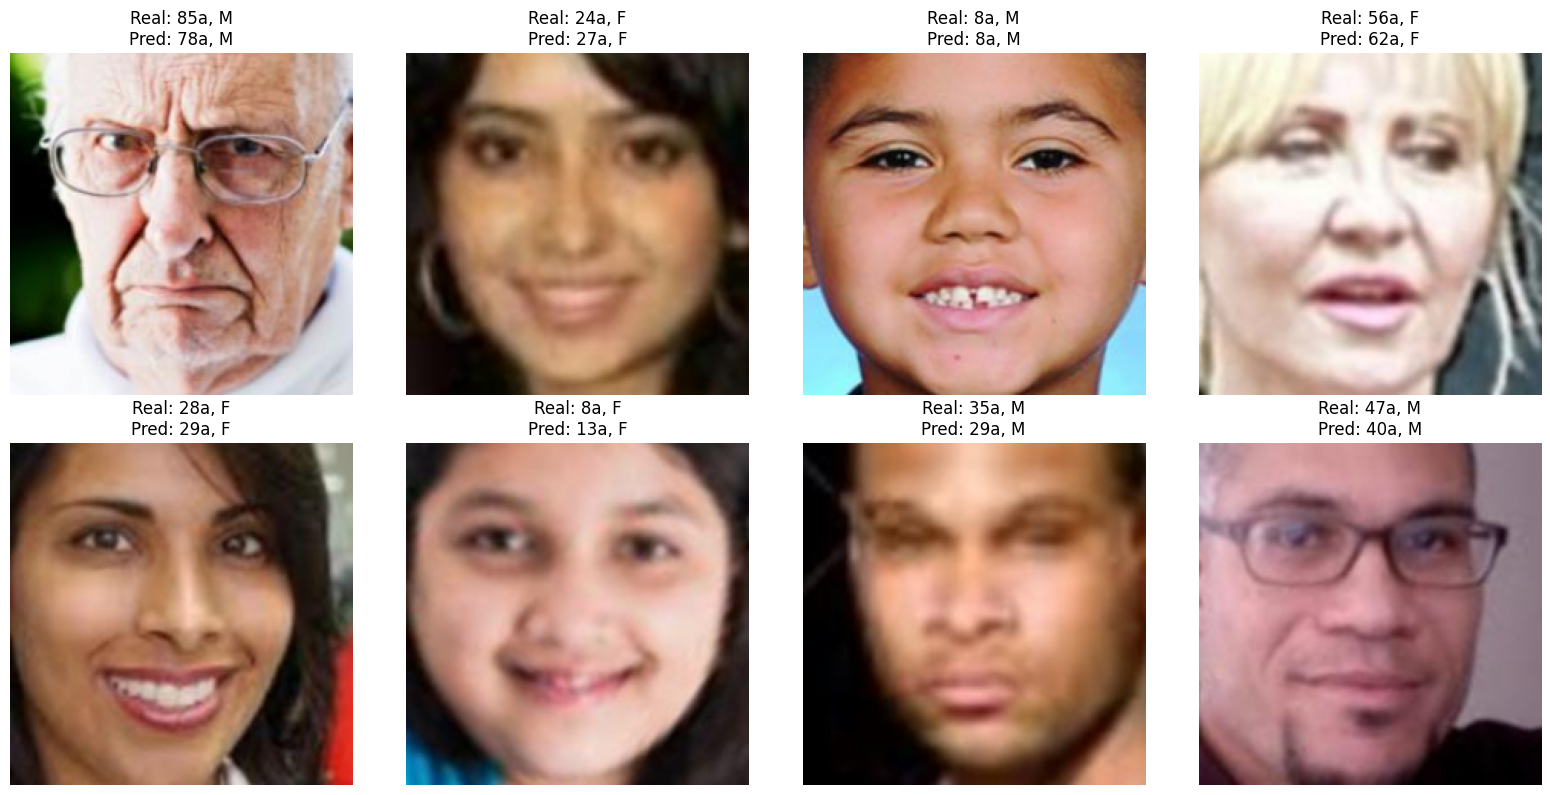

MAE de idade: 4.83 anos
Melhor acurácia de gênero: 84.56%


In [8]:
if __name__ == "__main__":
    DATA_DIR = '/kaggle/input/utkface-new/UTKFace'
    
     # Carregar dados
    print("\n1. Carregando dados")
    image_paths = load_data(DATA_DIR)
    
    # Dividir em treino e validação
    train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
    print(f'Imagens de treino: {len(train_paths)}')
    print(f'Imagens de validação: {len(val_paths)}')
    
    # Criar datasets
    train_dataset = UTKFaceDataset(train_paths, transform=train_transforms)
    val_dataset = UTKFaceDataset(val_paths, transform=val_transforms)
    
    # Criar dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # Criar modelo
    print("\n2. Criando modelo")
    model = AgeGenderNet().to(device)
    print(f'Total de parâmetros: {sum(p.numel() for p in model.parameters())}')
    
    # Definir funções de perda e otimizador
    criterion_age = nn.MSELoss()  # Mean Squared Error para idade
    criterion_gender = nn.CrossEntropyLoss()  # Cross Entropy para gênero
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # Treinamento
    print("\n3. Treinamento")
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_age_loss': [], 'val_age_loss': [],
        'train_gender_loss': [], 'val_gender_loss': [],
        'train_gender_acc': [], 'val_gender_acc': [],
        'val_age_mae': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(NUM_EPOCHS):
        print(f'\n{"="*80}')
        print(f'ÉPOCA {epoch+1}/{NUM_EPOCHS}')
        print("="*80)
        
        # Treinar
        train_loss, train_age_loss, train_gender_loss, train_gender_acc = train_epoch(
            model, train_loader, criterion_age, criterion_gender, optimizer, device, epoch, NUM_EPOCHS
        )
        
        # Validar
        print(f'\n{"Validando...":<20}', end='')
        val_loss, val_age_loss, val_gender_loss, val_gender_acc, val_age_mae = validate(
            model, val_loader, criterion_age, criterion_gender, device
        )
        
        # Ajustar learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Salvar histórico
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_age_loss'].append(train_age_loss)
        history['val_age_loss'].append(val_age_loss)
        history['train_gender_loss'].append(train_gender_loss)
        history['val_gender_loss'].append(val_gender_loss)
        history['train_gender_acc'].append(train_gender_acc)
        history['val_gender_acc'].append(val_gender_acc)
        history['val_age_mae'].append(val_age_mae)
        
        # Resumo da época
        print(f'\n{"RESUMO DA ÉPOCA":^80}')
        print("-"*80)
        print(f'{"TREINO":<40} | {"VALIDAÇÃO":<39}')
        print("-"*80)
        print(f'Loss Total: {train_loss:<27.4f} | Loss Total: {val_loss:<27.4f}')
        print(f'Loss Idade: {train_age_loss:<27.4f} | Loss Idade: {val_age_loss:<27.4f}')
        print(f'Loss Gênero: {train_gender_loss:<26.4f} | Loss Gênero: {val_gender_loss:<26.4f}')
        print(f'Acurácia Gênero: {train_gender_acc:<21.2f}% | Acurácia Gênero: {val_gender_acc:<21.2f}%')
        print(f'{"":<40} | MAE Idade: {val_age_mae:<27.2f} anos')
        print("-"*80)
        print(f'Learning Rate: {current_lr:.6f}')
        
        # Salvar melhor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_age_gender_model.pth')
        else:
            print(f'  Melhor val_loss continua: {best_val_loss:.4f}')
    
    print("Terminou!")
    
    # Plotar curvas de aprendizado
    print("\n4. Gerando gráficos")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss total
    axes[0, 0].plot(history['train_loss'], label='Treino')
    axes[0, 0].plot(history['val_loss'], label='Validação')
    axes[0, 0].set_title('Loss Total')
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss de idade
    axes[0, 1].plot(history['train_age_loss'], label='Treino')
    axes[0, 1].plot(history['val_age_loss'], label='Validação')
    axes[0, 1].set_title('Loss de Idade (MSE)')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Acurácia de gênero
    axes[1, 0].plot(history['train_gender_acc'], label='Treino')
    axes[1, 0].plot(history['val_gender_acc'], label='Validação')
    axes[1, 0].set_title('Acurácia de Gênero')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Acurácia (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # MAE de idade
    axes[1, 1].plot(history['val_age_mae'])
    axes[1, 1].set_title('MAE de Idade (Validação)')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('MAE (anos)')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Visualizar algumas predições
    print("\n5. Visualizando predições")
    model.load_state_dict(torch.load('best_age_gender_model.pth'))
    visualize_predictions(model, val_loader, device, num_images=8)
    
    print(f"MAE de idade: {min(history['val_age_mae']):.2f} anos")
    print(f"Melhor acurácia de gênero: {max(history['val_gender_acc']):.2f}%")

In [ ]:
# Teste em imagem local

def test_on_local_image(model_path, image_path, device):
    """
    Testa o modelo em uma imagem local
    """
    # Carregar o modelo
    model = AgeGenderNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Carregar e preprocessar a imagem
    image = Image.open(image_path).convert('RGB')
    original_image = image.copy()
    
    # Aplicar transformações
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Fazer predição
    with torch.no_grad():
        age_pred, gender_pred = model(image_tensor)
        
        predicted_age = age_pred.item()
        gender_probs = torch.softmax(gender_pred, dim=1)
        predicted_gender = torch.argmax(gender_pred, dim=1).item()
        gender_confidence = gender_probs[0][predicted_gender].item()
    
    # Mostrar resultado
    plt.figure(figsize=(8, 6))
    plt.imshow(original_image)
    plt.axis('off')
    
    gender_str = 'Feminino' if predicted_gender == 1 else 'Masculino'
    title = f'Idade Predita: {predicted_age:.0f} anos\n'
    title += f'Gênero Predito: {gender_str} (Confiança: {gender_confidence:.2f})'
    plt.title(title, fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return predicted_age, predicted_gender, gender_confidence

image_path = 'teste.png' 
model_path = 'best_age_gender_model.pth'

try:
    predicted_age, predicted_gender, confidence = test_on_local_image(model_path, image_path, device)
    print(f"\nResultados:")
    print(f"Idade predita: {predicted_age:.0f} anos")
    print(f"Gênero predito: {'Feminino' if predicted_gender == 1 else 'Masculino'}")
    print(f"Confiança do gênero: {confidence:.2f}")
except FileNotFoundError:
    print("Arquivo de imagem não encontrado. Verifique o caminho da imagem.")
except Exception as e:
    print(f"Erro ao processar a imagem: {e}")

Arquivo de imagem não encontrado. Verifique o caminho da imagem.


C:\Users\Kheven\AppData\Local\Temp\ipykernel_2196\2302449170.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de